**Objective:** 

Demo the creation of a TreeMesh using points and surfaces


In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from SimPEG import (Mesh, Directives, Maps, 
                    InvProblem, Optimization, DataMisfit, 
                    Inversion, Utils, Regularization)

import scipy as sp
import numpy as np


In [3]:
from scipy.interpolate import NearestNDInterpolator
from SimPEG.Utils.matutils import mkvc
def meshBuilder(xyz, h, padDist, meshGlobal=None,
                expFact=1.3,
                meshType='TENSOR',
                verticalAlignment='top'):
    """
        Function to quickly generate a Tensor mesh
        given a cloud of xyz points, finest core cell size
        and padding distance.
        If a meshGlobal is provided, the core cells will be centered
        on the underlaying mesh to reduce interpolation errors.

        :param numpy.ndarray xyz: n x 3 array of locations [x, y, z]
        :param numpy.ndarray h: 1 x 3 cell size for the core mesh
        :param numpy.ndarray padDist: 2 x 3 padding distances [W,E,S,N,Down,Up]
        [OPTIONAL]
        :param numpy.ndarray padCore: Number of core cells around the xyz locs
        :object SimPEG.Mesh: Base mesh used to shift the new mesh for overlap
        :param float expFact: Expension factor for padding cells [1.3]
        :param string meshType: Specify output mesh type: "TensorMesh"

        RETURNS:
        :object SimPEG.Mesh: Mesh object

    """

    assert meshType in ['TENSOR', 'TREE'], ('Revise meshType. Only ' +
                                            ' TENSOR | TREE mesh ' +
                                            'are implemented')

    # Get extent of points
    limx = np.r_[xyz[:, 0].max(), xyz[:, 0].min()]
    limy = np.r_[xyz[:, 1].max(), xyz[:, 1].min()]
    limz = np.r_[xyz[:, 2].max(), xyz[:, 2].min()]

    # Get center of the mesh
    midX = np.mean(limx)
    midY = np.mean(limy)

    if verticalAlignment == 'center':
        midZ = np.mean(limz)
    else:
        midZ = limz[0]

    nCx = int(limx[0]-limx[1]) / h[0]
    nCy = int(limy[0]-limy[1]) / h[1]
    nCz = int(limz[0]-limz[1]+int(np.min(np.r_[nCx, nCy])/3)) / h[2]

    if meshType == 'TENSOR':
        # Make sure the core has odd number of cells for centereing
        # on global mesh
        if meshGlobal is not None:
            nCx += 1 - int(nCx % 2)
            nCy += 1 - int(nCy % 2)
            nCz += 1 - int(nCz % 2)

        # Figure out paddings
        def expand(dx, pad):
            L = 0
            nC = 0
            while L < pad:
                nC += 1
                L = np.sum(dx * expFact**(np.asarray(range(nC))+1))

            return nC

        # Figure number of padding cells required to fill the space
        npadEast = expand(h[0], padDist[0, 0])
        npadWest = expand(h[0], padDist[0, 1])
        npadSouth = expand(h[1], padDist[1, 0])
        npadNorth = expand(h[1], padDist[1, 1])
        npadDown = expand(h[2], padDist[2, 0])
        npadUp = expand(h[2], padDist[2, 1])

        # Create discretization
        hx = [(h[0], npadWest, -expFact),
              (h[0], nCx),
              (h[0], npadEast, expFact)]
        hy = [(h[1], npadSouth, -expFact),
              (h[1], nCy), (h[1],
              npadNorth, expFact)]
        hz = [(h[2], npadDown, -expFact),
              (h[2], nCz),
              (h[2], npadUp, expFact)]

        # Create mesh
        mesh = Mesh.TensorMesh([hx, hy, hz], 'CC0')

        # Re-set the mesh at the center of input locations
        # Set origin
        if verticalAlignment == 'center':
            mesh.x0 = [midX-np.sum(mesh.hx)/2., midY-np.sum(mesh.hy)/2., midZ - np.sum(mesh.hz)/2.]
        elif verticalAlignment == 'top':
            mesh.x0 = [midX-np.sum(mesh.hx)/2., midY-np.sum(mesh.hy)/2., midZ - np.sum(mesh.hz)]
        else:
            assert NotImplementedError("verticalAlignment must be 'center' | 'top'")

    elif meshType == 'TREE':

        # Figure out full extent required from input
        extent = np.max(np.r_[nCx * h[0] + padDist[0, :].sum(),
                              nCy * h[1] + padDist[1, :].sum(),
                              nCz * h[2] + padDist[2, :].sum()])

        maxLevel = int(np.log2(extent/h[0]))+1

        # Number of cells at the small octree level
        # For now equal in 3D

        nCx, nCy, nCz = 2**(maxLevel), 2**(maxLevel), 2**(maxLevel)

        # nCy = 2**(int(np.log2(extent/h[1]))+1)
        # nCz = 2**(int(np.log2(extent/h[2]))+1)

        # Define the mesh and origin
        mesh = Mesh.TreeMesh([np.ones(nCx)*h[0],
                              np.ones(nCx)*h[1],
                              np.ones(nCx)*h[2]])

        # Shift mesh if global mesh is used
        center = np.r_[midX, midY, midZ]
        if meshGlobal is not None:

            tree = cKDTree(meshGlobal.gridCC)
            _, ind = tree.query(center, k=1)
            center = meshGlobal.gridCC[ind, :]

        # Set origin
        if verticalAlignment == 'center':
            mesh.x0 = np.r_[center[0] - (nCx-1)*h[0]/2., center[1] - (nCy-1)*h[1]/2., center[2] - (nCz-1)*h[2]/2.]
        elif verticalAlignment == 'top':
            mesh.x0 = np.r_[center[0] - (nCx-1)*h[0]/2., center[1] - (nCy-1)*h[1]/2., center[2] - (nCz-1)*h[2]]
        else:
            assert NotImplementedError("verticalAlignment must be 'center' | 'top'")

    return mesh


def refineTree(mesh, xyz, finalize=False, dtype="point", nCpad=[1, 1, 1]):

    maxLevel = int(np.log2(mesh.hx.shape[0]))

    if dtype == "point":

        mesh.insert_cells(xyz, np.ones(xyz.shape[0])*maxLevel, finalize=False)

        stencil = np.r_[
                np.ones(nCpad[0]),
                np.ones(nCpad[1])*2,
                np.ones(nCpad[2])*3
            ]

        # Reflect in the opposite direction
        vec = np.r_[stencil[::-1], 1, stencil]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        gridLevel = np.maximum(np.maximum(np.abs(vecX),
                               np.abs(vecY)), np.abs(vecZ))
        gridLevel = np.kron(np.ones((xyz.shape[0], 1)), gridLevel)

        # Grid the coordinates
        vec = np.r_[-np.cumsum(stencil)[::-1], 0, np.cumsum(stencil)]
        vecX, vecY, vecZ = np.meshgrid(vec, vec, vec)
        offset = np.c_[
            mkvc(np.sign(vecX)*np.abs(vecX) * mesh.hx.min()),
            mkvc(np.sign(vecY)*np.abs(vecY) * mesh.hy.min()),
            mkvc(np.sign(vecZ)*np.abs(vecZ) * mesh.hz.min())
        ]

        # Replicate the point locations in each offseted grid points
        newLoc = (
            np.kron(xyz, np.ones((offset.shape[0], 1))) +
            np.kron(np.ones((xyz.shape[0], 1)), offset)
        )

        mesh.insert_cells(
            newLoc, maxLevel-mkvc(gridLevel)+1, finalize=finalize
        )

    elif dtype == 'surface':

        # Get extent of points
        limx = np.r_[xyz[:, 0].max(), xyz[:, 0].min()]
        limy = np.r_[xyz[:, 1].max(), xyz[:, 1].min()]

        F = NearestNDInterpolator(xyz[:, :2], xyz[:, 2])
        zOffset = 0
        # Cycle through the first 3 octree levels
        for ii in range(3):

            dx = mesh.hx.min()*2**ii

            # Horizontal offset
            xyOff = dx * 2

            nCx = int(limx[0]-limx[1] + 2 * xyOff) / dx
            nCy = int(limy[0]-limy[1] + 2 * xyOff) / dx

            # Create a grid at the octree level in xy
            CCx, CCy = np.meshgrid(
                np.linspace(limx[1]-xyOff, limx[0]+xyOff, nCx),
                np.linspace(limy[1]-xyOff, limy[0]+xyOff, nCy)
            )

            z = F(mkvc(CCx), mkvc(CCy))

            for level in range(int(nCpad[ii])):

                mesh.insert_cells(
                    np.c_[mkvc(CCx), mkvc(CCy), z-zOffset], np.ones_like(z)*maxLevel-ii,
                    finalize=False
                )

                zOffset += dx

        if finalize:
            mesh.finalize()

    else:
        NotImplementedError("Only dtype='points' has been implemented")

    return mesh

In [4]:
# Create grid of points for topography
# Lets create a simple Gaussian topo and set the active cells
[xx, yy] = np.meshgrid(np.linspace(-200,200,50), np.linspace(-200,200,50))
b = 100
A = 50
zz = A*np.exp(-0.5*((xx/b)**2. + (yy/b)**2.))

# We would usually load a topofile
topo = np.c_[Utils.mkvc(xx), Utils.mkvc(yy), Utils.mkvc(zz)]

# Create and array of observation points
xr = np.linspace(-100., 100., 20)
yr = np.linspace(-100., 100., 20)
X, Y = np.meshgrid(xr, yr)
Z = A*np.exp(-0.5*((X/b)**2. + (Y/b)**2.)) + 5

xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

# Create a mesh with extent based on topo
h = [5,5,5] # Cell size
padDist = np.ones((3,2)) * 100 # How far outside the given object you want to padd

mesh = meshBuilder(topo, h, padDist,
                    meshType='TREE', meshGlobal=None,
                    verticalAlignment='center')

# Refine the mesh around topography
mesh = refineTree(
    mesh, topo, dtype='surface',
    nCpad=[0, 5, 3], finalize=False
)

# Refine around obs points
mesh = Utils.modelutils.refineTree(
    mesh, xyzLoc, dtype='point',
    nCpad=[2, 0, 0], finalize=True
)


# Define an active cells from topo
actv = Utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
Mesh.TreeMesh.writeUBC(mesh, 'OctreeMesh.msh',
                               models={'ActiveOctree.dat': actv})

C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\ipykernel_launcher.py:201: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\ipykernel_launcher.py:202: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


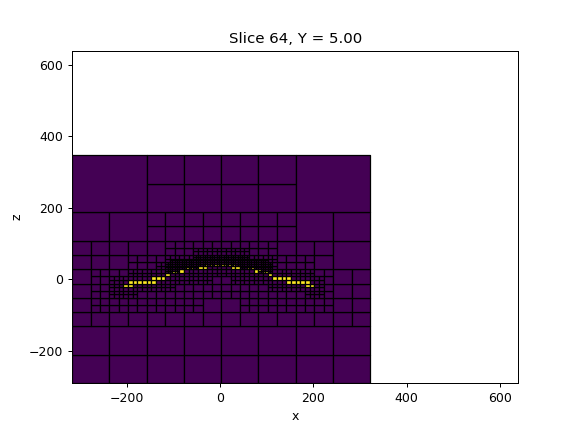

(<matplotlib.cm.ScalarMappable at 0x1bbcc50ed30>,)

In [5]:
from scipy.spatial import cKDTree
def getLayer(mesh, topo, index=0):
    """
        Find the ith layer below topo
    """

    actv = np.zeros(mesh.nC, dtype='bool')
    # Get cdkTree to find top layer
    tree = cKDTree(mesh.gridCC)
    def ismember(a, b):
        bind = {}
        for i, elt in enumerate(b):
            if elt not in bind:
                bind[elt] = i
        return np.vstack([bind.get(itm, None) for itm in a])

    r, inds = tree.query(topo)
    inds = np.unique(inds)

    # Extract neighbors from operators
    Dz = mesh._cellGradzStencil
    Iz,Jz,_ = sp.sparse.find(Dz)
    jz = np.sort(Jz[np.argsort(Iz)].reshape((int(Iz.shape[0]/2),2)),axis=1)
    for ii in range(index):

        members = ismember(inds, jz[:,1])
        inds = np.squeeze(jz[members,0])

    actv[inds] = True

    return actv


actv = getLayer(mesh, topo, index=2)
mesh.plotSlice(actv, normal='Y')

<IPython.core.display.Javascript object>


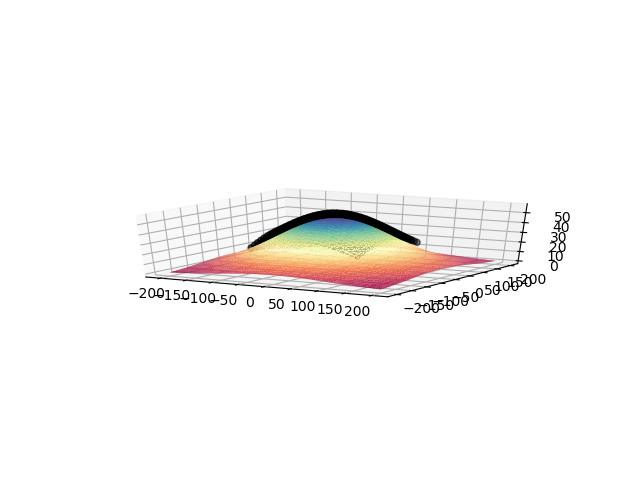

In [6]:
# Here how the topo looks with a quick interpolation, just a Gaussian...
tri = sp.spatial.Delaunay(topo)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(topo[:,0], topo[:,1], topo[:,2], triangles=tri.simplices, cmap=plt.cm.Spectral)
ax.scatter3D(xyzLoc[:,0],xyzLoc[:,1],xyzLoc[:,2], c='k')
ax.set_aspect(1./4)
plt.show()

In [9]:
import zarr
import numcodecs
import dask
# Save mesh to zarr
z = zarr.empty(1, dtype=object, object_codec=numcodecs.Pickle())
z[0] = mesh

In [12]:
zarr.save('Mytree.zarr', z,  object_codec=numcodecs.Pickle())

ValueError: missing object_codec for object array

In [14]:
import pickle